In [1]:
%matplotlib nbagg

In [2]:
import os
import contextlib
import glob

import matplotlib.pyplot as plt
import numpy as np

import libertem.api as lt
from libertem.executor.inline import InlineJobExecutor
from libertem.udf.base import UDF
from libertem.common.buffers import reshaped_view

In [3]:
sourcefolder = '/cachedata/users/clausen/libertem-test-data/'
targetfolder = '/cachedata/users/weber/libertem-test-data-raw/'
assert os.path.exists(sourcefolder)
assert os.path.exists(targetfolder)

In [4]:
relpath = 'Capture52/Capture52_.gtg'
ctx = lt.Context(executor=InlineJobExecutor())
ds = ctx.load('auto', path=os.path.join(sourcefolder, relpath))

/cachedata/users/weber/LiberTEM-uellue/src/libertem/utils/devices.py:19: RuntimeWarning: ImportError('CuPy is not correctly installed.\n\nIf you are using wheel distribution (cupy-cudaXX), make sure that the version of CuPy you installed matches with the version of CUDA on your host.\nAlso, confirm that only one CuPy package is installed:\n  $ pip freeze\n\nIf you are building CuPy from source, please check your environment, uninstall CuPy and reinstall it with:\n  $ pip install cupy --no-cache-dir -vvvv\n\nCheck the Installation Guide for details:\n  https://docs.cupy.dev/en/latest/install.html\n\noriginal error: libcudart.so.10.1: cannot open shared object file: No such file or directory')
  warnings.warn(repr(e), RuntimeWarning)


In [5]:
k2is_data = np.memmap(
    os.path.join(targetfolder, 'Capture52/Capture52_.gtg_(34, 35, 1860, 2048)_uint16.raw'),
    shape=(34, 35, 1860, 2048),
    dtype=np.uint16,
    mode='r'
)

In [6]:
class ValidationUDF(UDF):
    '''
    UDF to compare a dataset against an array-like
    object using a validation function, by default np.allclose().

    Note that the reference should have a flattened nav and the ROI already
    applied since it is compared directly with meta.slice.get()!

    Only works efficiently on large datasets with an inline executor!
    '''
    def __init__(self,
            reference,
            preferred_dtype=UDF.USE_NATIVE_DTYPE,
            validation_function=np.allclose):
        super().__init__(
            reference=reference,
            preferred_dtype=preferred_dtype,
            validation_function=validation_function
        )

    def get_preferred_input_dtype(self):
        return self.params.preferred_dtype

    def get_result_buffers(self):
        return {
            # Just a buffer to "feel" the av shape
            'nav_shape': self.buffer(kind="nav", dtype="float32"),
        }

    def process_tile(self, tile):
        assert self.params.validation_function(
            self.meta.slice.get(self.params.reference), tile
        )

In [7]:
udf = ValidationUDF(
    reference=reshaped_view(k2is_data, (-1, *tuple(ds.shape.sig)))
)
ctx.run_udf(udf=udf, dataset=ds)

AssertionError: 

0 0


<IPython.core.display.Javascript object>


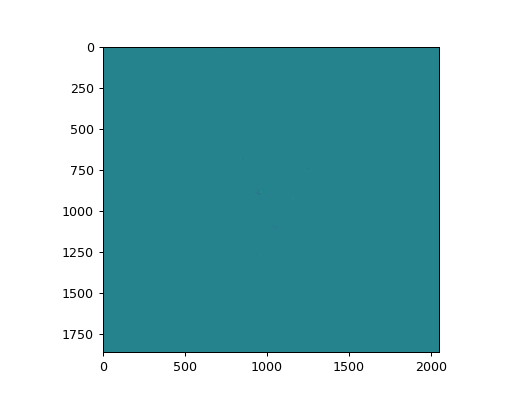

In [14]:
for y in range(34):
    for x in range(35):
        a = ctx.create_pick_analysis(dataset=ds, y=y, x=x)
        res = ctx.run(a)
        print(y, x)
        fig, axes = plt.subplots()
        axes.imshow(k2is_data[y,x].astype(np.float32) - k2is_data[y,x+1].astype(np.float32))
        break
    break